## Imports

In [1]:
import os, sys
sys.path.append("..")

import torch
import torch.nn.functional as F
import wandb
import random
from math import pi
import numpy as np
from tqdm import tqdm
from sklearn import mixture
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ot

from src.ulight_ot import ULightOT
from src.plotters import plot_2D_lines_p0
from src.distributions import MixtureNormalSampler_outliers

%load_ext autoreload
%autoreload 2

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Config

In [2]:
DIM = 2
assert DIM > 1

OUTPUT_SEED = 42

K_POTENTIALS = L_POTENTIALS = 10
DIVERGENCE = "KL" # 'KL' "Xi2"
Tau = 1
INIT_BY_SAMPLES = True
IS_DIAGONAL = True

BATCH_SIZE = 128
SAMPLING_BATCH_SIZE = 128

EPS = EPSILON = 0.05

LR = 1e-3
D_GRADIENT_MAX_NORM = float("inf")

PLOT_EVERY = 2000
MAX_STEPS = 20000
CONTINUE = -1

In [3]:
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)

In [4]:
EXP_NAME = f'ULightOT_Gauss_outliers_{EPSILON}'
OUTPUT_PATH = '../checkpoints/{}'.format(EXP_NAME)

config = dict(
    DIM=DIM,
    LR=LR,
    BATCH_SIZE=BATCH_SIZE,
    EPSILON=EPSILON,
    D_GRADIENT_MAX_NORM=D_GRADIENT_MAX_NORM,
    K_POTENTIALS=K_POTENTIALS,
    L_POTENTIALS=L_POTENTIALS,
    INIT_BY_SAMPLES=INIT_BY_SAMPLES,
    IS_DIAGONAL=IS_DIAGONAL,
)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## Create samplers

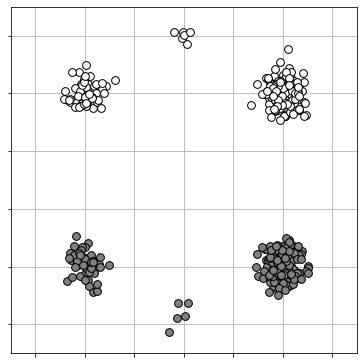

In [5]:
X_sampler = MixtureNormalSampler_outliers(weights=(0.25, 0.73, 0.02), loc0=(-3, 3), loc1=(1, 3), loc2=(-1,4))
Y_sampler = MixtureNormalSampler_outliers(weights=(0.25, 0.73, 0.02), loc0=(-3, 0), loc1=(1, 0), loc2=(-1,-1))
x_p = X_sampler.sample(250)
y_q = Y_sampler.sample(250)

fig,axes = plt.subplots(1, 1, figsize=(5,5),squeeze=True,sharex=True,sharey=True)
axes.scatter(x_p[:, 0], x_p[:, 1],  s=60,c='white', edgecolors='black', zorder=3, label = r'$x\sim p$', alpha=1)
axes.scatter(y_q[:, 0], y_q[:, 1], s=60,c='grey', edgecolors='black', zorder=3, label = r'$y\sim q$', alpha=1)

lims=((-4.5, 2.5), (-1.5, 4.5))

axes.set_xlim(*lims[0])
axes.set_ylim(*lims[1])
axes.set_yticklabels([])
axes.set_xticklabels([])
axes.grid(True)
fig.tight_layout(pad=0.5)

## Model initialization

In [6]:
D = ULightOT(dim=DIM, k_potentials=K_POTENTIALS, l_potentials=L_POTENTIALS,epsilon=EPSILON,
            sampling_batch_size=SAMPLING_BATCH_SIZE, is_diagonal=IS_DIAGONAL)

log_m = torch.zeros(1, requires_grad=True)

if INIT_BY_SAMPLES:
    D.init_r_by_samples(Y_sampler.sample(K_POTENTIALS))

D_opt = torch.optim.Adam(D.parameters(), lr=LR)
m_opt = torch.optim.Adam([log_m], lr=LR)

if CONTINUE > -1:
    D_opt.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'D_opt_{SEED}_{CONTINUE}.pt')))

## Model training

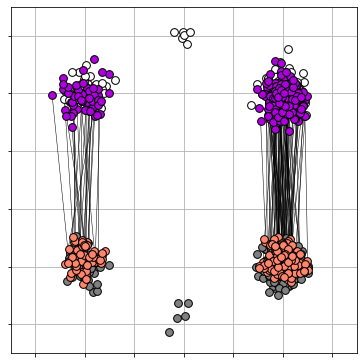

100%|██████████| 20000/20000 [02:27<00:00, 135.48it/s]


Results for Tau:  1


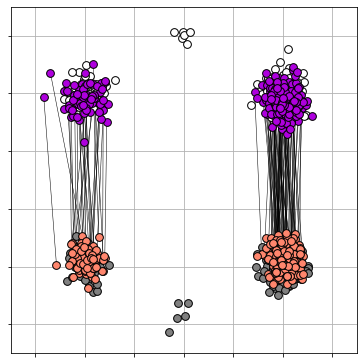

In [7]:
for step in tqdm(range(0, MAX_STEPS)):
    D_opt.zero_grad(); m_opt.zero_grad();
    if step < 2000:
        tau = 1000
    else:
        tau = Tau

    X, Y = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)

    log_V = D.get_potential(Y)
    psi = EPSILON * log_V + torch.norm(Y, p=2, dim=-1)**2/2
    if DIVERGENCE == 'KL':
        f_psi = tau * (torch.exp(-psi/tau) - 1)
    elif DIVERGENCE == 'Xi2':
        psi = -(F.relu(-psi + 2*tau) - (1+(-psi>-2*tau))*tau)
        f_psi = 0.25 * psi**2/tau - psi


    log_C = D.get_C(X)
    log_U = D.get_marginal(X)
    phi = EPSILON * (log_U + log_m - log_C) + torch.norm(X, p=2, dim=-1)**2/2

    if DIVERGENCE == 'KL':
        f_phi = tau * (torch.exp(-phi/tau) - 1)
    elif DIVERGENCE == 'Xi2':
        phi = -(F.relu(-phi + 2*tau) - (1+(-phi>-2*tau))*tau)
        f_phi = 0.25 * phi**2/tau - phi

    D_loss = EPSILON * torch.exp(log_m) + f_phi.mean() + f_psi.mean()
    D_loss.backward()
    D_opt.step(); m_opt.step();

    if step % PLOT_EVERY == 0:
        torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'D_{Tau}.pt'))
        
        clear_output(wait=True)
        fig = plot_2D_lines_p0(step, D, x_p, y_q, lims=lims)
        plt.show()

print('Results for Tau: ', tau)
fig = plot_2D_lines_p0(step, D, x_p, y_q, lims=lims)
plt.show()